Uploading the libraries needed

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm
import os
import PIL
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report



Read the table and create an array with one image from each class

In [2]:
clases_path = os.listdir('EuroSAT_RGB/')
clases_path = [l for l in clases_path if not l.startswith('.')]
img_paths = [os.path.join('EuroSAT_RGB/',l,l+'_1000.jpg') for l in clases_path]



We plot one image for each class

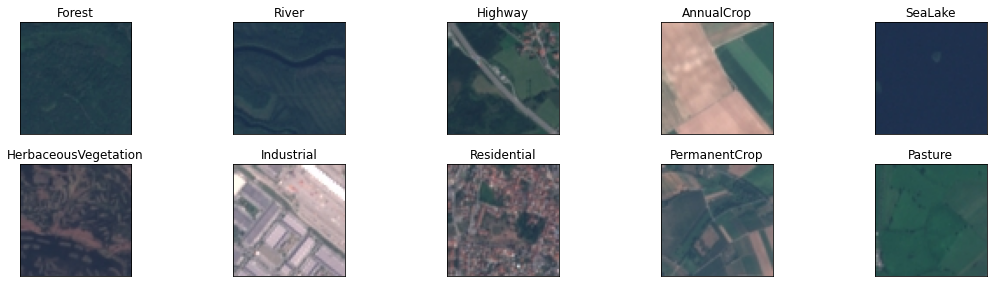

In [3]:
def plot_sat_imgs(paths, labels):
    plt.figure(figsize=(15, 8))
    for i in range(len(img_paths)):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(labels[i])  

plot_sat_imgs(img_paths, clases_path)
plt.tight_layout()
plt.show()



Reading the file with the different class images and spliting the data into a random test/train

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
totaldata = torchvision.datasets.ImageFolder(root='EuroSAT_RGB/',transform=transform)

n = len(totaldata) 
test_size = int(0.2*n)
train_size = n-test_size

test_set, train_set = random_split(totaldata, [train_size, test_size],generator=torch.Generator().manual_seed(42))



Loading the images to get the mean and standard deviation on the train dataset in order to put those inputs in the normalization

In [5]:
image_file_loader = DataLoader(
    train_set,
    # batch size is whole dataset
    batch_size=len(train_set),
    shuffle=False,
    num_workers=2)

def mean_std(file):
    images, labels = next(iter(file))
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

mean, std = mean_std(image_file_loader)
print("mean and std: \n", mean, std)




mean and std: 
 tensor([0.3465, 0.3814, 0.4080]) tensor([0.2035, 0.1363, 0.1144])


Normalizing the hole data based on the previous mean and standard deviation. And splitting the normalized images between train and set

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.3465, 0.3814, 0.4080), (0.2035, 0.1363, 0.1144))])

totaldata = torchvision.datasets.ImageFolder(root='EuroSAT_RGB/',transform=transform)
n = len(totaldata) 
test_size = int(0.2*n)
train_size = n-test_size

test_set, train_set = random_split(totaldata, [train_size, test_size],generator=torch.Generator().manual_seed(42))




Loading the train and test datasets

In [7]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, #256 is about 1% of my data
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                         shuffle=True, num_workers=2)



Showing the first 4 images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


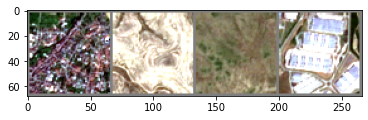

class_name: Residential HerbaceousVegetation HerbaceousVegetation Industrial


In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print('class_name:', ' '.join('%s' % totaldata.classes[labels[j].item()] for j in range(4)))




Setting the neural net

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 5, 1)  # in_channels, out_channels, kernel_size, stride(#pixels it moves)
        self.conv2 = nn.Conv2d(64, 64, 3, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, 2)
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(6272, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


Define a criterion and an optimizer for our neural net

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())




Running 5 epochs of the neural nets showing the actual and predicted clases every 40

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


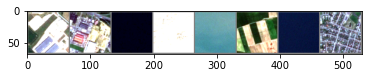

Predicted: AnnualCrop Residential SeaLake River Residential Forest SeaLake Highway
Real: Industrial Industrial SeaLake HerbaceousVegetation SeaLake AnnualCrop SeaLake Residential


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


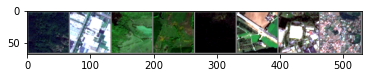

Predicted: SeaLake Residential SeaLake Forest Forest AnnualCrop Industrial Residential
Real: Forest Industrial Pasture Pasture Forest Highway Industrial Residential


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


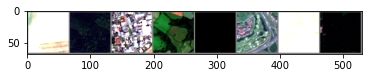

Predicted: PermanentCrop SeaLake Industrial SeaLake SeaLake Industrial AnnualCrop Forest
Real: AnnualCrop Forest Industrial Pasture SeaLake Highway PermanentCrop Forest
Epoch 1, Loss: 1.911457244087668
Accuracy of the network on test images: 33 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


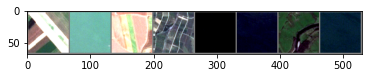

Predicted: AnnualCrop SeaLake AnnualCrop Highway River River River Forest
Real: AnnualCrop SeaLake AnnualCrop PermanentCrop SeaLake SeaLake River SeaLake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


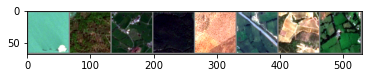

Predicted: Pasture River River SeaLake AnnualCrop River HerbaceousVegetation River
Real: SeaLake Forest Pasture Forest PermanentCrop Highway PermanentCrop Pasture


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


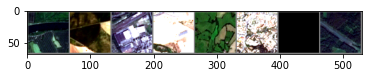

Predicted: River HerbaceousVegetation Industrial Residential AnnualCrop Residential Forest River
Real: River AnnualCrop Industrial Industrial Pasture Residential SeaLake River
Epoch 2, Loss: 1.4673488813288071
Accuracy of the network on test images: 33 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


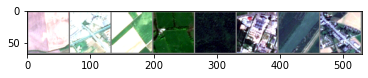

Predicted: AnnualCrop Industrial AnnualCrop Pasture Forest Industrial Pasture Highway
Real: AnnualCrop Highway AnnualCrop Pasture Forest Industrial River Highway


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


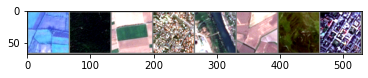

Predicted: Pasture Forest AnnualCrop Residential River PermanentCrop HerbaceousVegetation Industrial
Real: Pasture Forest AnnualCrop Residential River AnnualCrop HerbaceousVegetation Residential


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


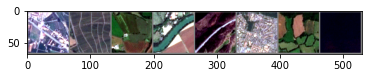

Predicted: Industrial River Pasture Highway River Residential Pasture Forest
Real: Highway PermanentCrop Pasture River Highway Residential Pasture SeaLake
Epoch 3, Loss: 1.2382341132444494
Accuracy of the network on test images: 62 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


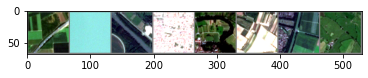

Predicted: River Forest Highway PermanentCrop Residential PermanentCrop Highway Pasture
Real: Highway SeaLake River Residential River PermanentCrop Highway Pasture


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


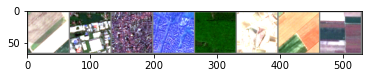

Predicted: AnnualCrop Highway Residential Residential Pasture PermanentCrop AnnualCrop AnnualCrop
Real: AnnualCrop Industrial Residential Residential Forest PermanentCrop AnnualCrop AnnualCrop


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


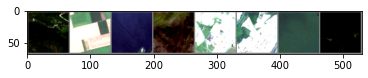

Predicted: SeaLake AnnualCrop SeaLake SeaLake Industrial Industrial SeaLake SeaLake
Real: Forest AnnualCrop SeaLake HerbaceousVegetation Industrial Industrial SeaLake Forest
Epoch 4, Loss: 1.1431419849395752
Accuracy of the network on test images: 58 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


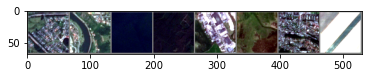

Predicted: Residential River Forest Forest Industrial HerbaceousVegetation Residential AnnualCrop
Real: Residential River SeaLake Forest Industrial HerbaceousVegetation Residential AnnualCrop


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


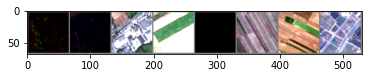

Predicted: Forest SeaLake Industrial AnnualCrop SeaLake PermanentCrop AnnualCrop Industrial
Real: Forest Forest Industrial AnnualCrop SeaLake AnnualCrop AnnualCrop Highway


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


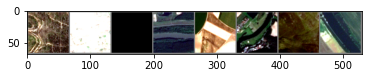

Predicted: PermanentCrop HerbaceousVegetation Forest HerbaceousVegetation PermanentCrop River HerbaceousVegetation River
Real: HerbaceousVegetation PermanentCrop SeaLake River AnnualCrop River HerbaceousVegetation River
Epoch 5, Loss: 1.0232201471048243
Accuracy of the network on test images: 62 %
Finished Training


In [11]:
# Number of training epochs
num_epochs = 5

testiter = iter(testloader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 40 == 0:
            with torch.no_grad():
                # Show a sample of images from the test data and model's predictions
                test_images, test_labels = testiter.next()
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = net(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                total += test_labels[:8].size(0)
                correct += (predicted == test_labels[:8]).sum().item()
                
                print('Predicted:', ' '.join('%s' % totaldata.classes[predicted[j].item()] for j in range(8)))
                print('Real:', ' '.join('%s' % totaldata.classes[test_labels[j].item()] for j in range(8)))


    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")
    print('Accuracy of the network on test images: %d %%' % (100*correct/total))
    
print('Finished Training')




Saving the neural net

In [12]:
PATH = './EuroSAT_RGB_CNN.path'
torch.save(net.state_dict(),PATH)

net = Net()
net.load_state_dict(torch.load(PATH))



<All keys matched successfully>

Score the a batch of the test dataset to print some images, the prediction and the real score.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


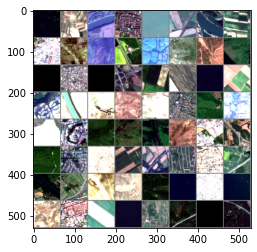

Predicted: SeaLake PermanentCrop River Residential SeaLake AnnualCrop River Highway
Real: Forest PermanentCrop River Residential SeaLake Highway River AnnualCrop


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

test_outputs = net(images)
_, predicted = torch.max(test_outputs, 1)

imshow(torchvision.utils.make_grid(images))
print('Predicted:', ' '.join('%s' % totaldata.classes[predicted[j].item()] for j in range(8)))
print('Real:', ' '.join('%s' % totaldata.classes[labels[j].item()] for j in range(8)))




Predicting all test_outputs and saving the results to get all predictions and labels and printing the main accuracy of the model

In [14]:
correct = 0
total = 0
predicted_ls = []
labels_ls = []
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        predicted_ls += predicted
        labels_ls += labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the netwoek on test images: %d %%' % (100*correct/total))
        
        

Accuracy of the netwoek on test images: 60 %


Printing the Confusion matrix for all 10 classes

In [15]:
confusion_m = confusion_matrix(labels_ls, predicted_ls)
confusion_m = pd.DataFrame(confusion_m,columns=totaldata.classes,index=totaldata.classes)
confusion_m

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,1509,22,103,57,6,204,289,0,130,49
Forest,0,512,24,0,0,92,0,0,29,1761
HerbaceousVegetation,43,12,1325,95,64,63,421,180,140,45
Highway,86,0,68,754,182,41,212,149,481,2
Industrial,0,0,1,28,1915,0,3,53,16,0
Pasture,21,36,171,12,0,900,11,0,170,283
PermanentCrop,122,0,519,152,71,54,881,72,120,3
Residential,0,0,39,59,294,0,36,1955,11,0
River,63,31,32,253,30,176,23,12,1337,46
SeaLake,23,224,40,5,1,204,15,2,50,1875


Printing the classification score for all 10 classes.


In [20]:
class_report = classification_report(labels_ls, predicted_ls,output_dict=True)
class_report = pd.DataFrame(class_report)
class_report.columns = totaldata.classes + ['accuracy','macro avg','weighted avg']
class_report


,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake,accuracy,macro avg,weighted avg
precision,0.808249,0.611708,0.570629,0.532862,0.747171,0.519031,0.465891,0.806851,0.538245,0.461368,0.600139,0.606201,0.611653
recall,0.636978,0.211745,0.554858,0.381772,0.949901,0.561097,0.441825,0.816625,0.667499,0.768758,0.600139,0.599106,0.600139
f1-score,0.712465,0.314593,0.562633,0.444838,0.836427,0.539245,0.453539,0.811709,0.595944,0.576657,0.600139,0.584805,0.586553
support,2369.000000,2418.000000,2388.000000,1975.000000,2016.000000,1604.000000,1994.000000,2394.000000,2003.000000,2439.000000,0.600139,21600.000000,21600.000000


We can see that AnnualCrop, Residential and Industrial are the ones with higher accuracy. On the other hand, the landscape with lowest accuracy is PermanentCrop and seaLake. This last one makes sense since most of the images tag as SeaLake are hard to distinguish since some of them were greenish and those could be confused with HerbaceousVegetation or Forest
 

